# Linear gradient-descent Sarsa and DQN

###  Mountain Car 

The implementation of `MountainCar` is based on the problem description given in [Example 8.2](http://www.incompleteideas.net/book/ebook/node89.html) of Sutton & Barto (1998) The following cells in this section will walk you through the basic usage of this class.

In [2]:
import numpy as np
import mountaincar

## Linear gradient-descent Sarsa using tile coding

The pseudo-code for  _Linear, gradient-descent Sarsa($\lambda$)_ is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, [Section 8.4](http://www.incompleteideas.net/book/ebook/node89.html#fig:FAsarsa).
<img src="images/gradient_descent_Sarsa.png" style="width: 500px;"/>

In [13]:
# Please write your code in this cell. You can add additional code cells below this one, if you would like to.
# ...
import matplotlib.pyplot as plt

class tile_coder:
    def __init__(self, 
                 num_tiles = 9, 
                 num_tilings = 10, 
                 min_X = env.position_min, 
                 max_X = env.position_max, 
                 min_Y = env.velocity_min, 
                 max_Y = env.velocity_max):
        self.min_X = min_X
        self.max_X = max_X
        self.min_Y = min_Y
        self.max_Y = max_Y
        self.num_tiles = num_tiles
        self.num_tilings = num_tilings
        self.tile_width = (self.max_X - self.min_X) / (self.num_tiles - 1)
        self.tile_height = (self.max_Y - self.min_Y) / (self.num_tiles - 1)
        self.offset_X = self.tile_width / (self.num_tiles - 1)
        self.offset_Y = self.tile_height / (self.num_tiles - 1)
        
    def get_indice(self, position, velocity, action):
        indices = [0] * self.num_tilings
        position -= self.min_X
        velocity -= self.min_Y
        for tiling in range(self.num_tilings):
            new_x = int(position / self.tile_width)
            new_y = int(velocity / self.tile_height)
            index = (new_y * self.num_tiles + new_x) + tiling * self.num_tiles * self.num_tiles
            index = index + action * tiling * self.num_tiles * self.num_tiles
            indices[tiling] = index
            
            position += self.offset_X
            velocity += self.offset_Y
            
        return indices 

    
class Linear_GD_Sarsa_Agent:
    def __init__(self, alpha = 0.01, greedy = 0.1, gamma = 1, lambada = 0.9):
        self.alpha = alpha
        self.greedy = greedy
        self.gamma = gamma
        self.lambada = lambada
        self.theta = np.zeros(3000)
        
    def choose_action(self, tile, env, enable_greedy = True):
        # enable_greedy = False is used for test only, never make the non-greedy move
        # default as True, have a probability to make the non-greedy move
        if enable_greedy:
            if np.random.rand(1) >= self.greedy:
                # choose greedy action
                q = {}
                for action in env.actions:
                    features_vector = tile.get_indice(env.position, env.velocity, action)
                    q[action] = self.theta[features_vector].sum()
                max_q = np.array([q[key] for key in q.keys()]).max()
                chosen_action = np.random.choice([key for key in q.keys() if q[key]==max_q])
                q_value = q[chosen_action]
            else:
                # choose not greedy action
                chosen_action = np.random.choice(env.actions)
                features_vector = tile.get_indice(env.position, env.velocity, chosen_action)
                q_value = self.theta[features_vector].sum() 
        else:
            # always choose greedy action
            q = {}
            for action in env.actions:
                features_vector = tile.get_indice(env.position, env.velocity, action)
                q[action] = self.theta[features_vector].sum()
            max_q = np.array([q[key] for key in q.keys()]).max()
            chosen_action = np.random.choice([key for key in q.keys() if q[key]==max_q])
            q_value = q[chosen_action]

        return chosen_action, q_value
    
    def learn(self, delta, e):
        self.theta = self.theta + self.alpha * delta * e
        

def simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'accumulating'):
    # trace_type means the eligibility tracing type, either accumulating or replacing
    # default as accumulating
    reward_ret = np.zeros(episodes)
    
    for episode in range(1, episodes+1):
        total_reward = 0
        env.reset()
        e = np.zeros(agent.theta.shape)
        # choose the initial action randomly
        current_action = agent.choose_action(tile, env)[0]
        features_vector = tile.get_indice(env.position, env.velocity, current_action)
        # for each step, learn
        while env.game_over == False:
            if trace_type == 'accumulating':   #accumulating trace
                e[features_vector] += 1
            elif trace_type == 'replacing':   #replacing trace
                e[features_vector] = 1
            else:
                raise ValueError("The tracing type %s should be either 'accumulating' or 'replacing'" \
                                 % trace_type)
                
            reward = env.make_step(current_action)
            total_reward += reward
            delta = reward - agent.theta[features_vector].sum()
            next_action, q_value = agent.choose_action(tile, env)
            delta = delta + agent.gamma * q_value
            agent.learn(delta, e)
            e = agent.gamma * agent.lambada * e
            # update for next step
            current_action = next_action
            features_vector = tile.get_indice(env.position, env.velocity, current_action)
        
        reward_ret[episode-1] = total_reward
        
    return reward_ret

In [14]:
# initial parameters
num_tiles = 9
num_tilings = 10

tile = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
agent_1 = Linear_GD_Sarsa_Agent(alpha = 0.1/num_tilings, greedy = 0.1, gamma = 1, lambada = 0.9)
env = mountaincar.MountainCar()
episodes = 5000
ret = simulate_Linear_GD_Sarsa(agent_1, env, episodes, trace_type = 'accumulating')

In [15]:
# test for how many steps it takes to reach the top if all the action is greedy
np.random.seed(7)
env = mountaincar.MountainCar()
env.reset()
print("Starting position of the car", env.position)
print("Starting velocity of the car", env.velocity)
num_steps = 10000 # large enough for the game ended
for step in range(num_steps):
    # Always action 1 (full throttle forward)
    action, _ = agent_1.choose_action(tile, env, enable_greedy = False)
    env.make_step(action=action)
    # env.plot()
    if env.game_over:
        print('It takes', step, 'steps to reach the top.')
        break      

Starting position of the car -0.454704306550481
Starting velocity of the car 0.03128512489633177
It takes 93 steps to reach the top.


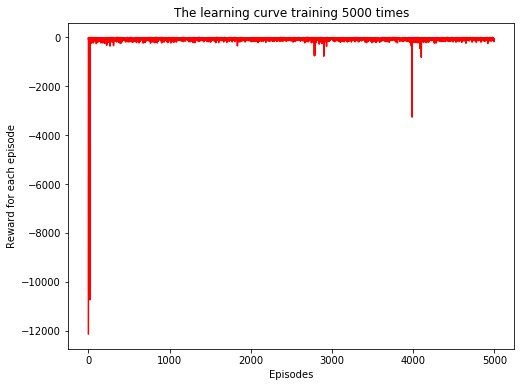

In [16]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(episodes), ret, color = 'r')
plt.xlabel('Episodes')
plt.ylabel('Reward for each episode')
plt.title('The learning curve training 5000 times')
plt.show()

## Deep Q Network (DQN)

In [18]:
# Please write your code in this cell. You can add additional code cells below this one, if you would like to.
# ...
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

class DQN_Agent:
    def __init__(self, alpha = 0.1, greedy = 0.1, gamma = 1):
        self.memory = deque(maxlen=2000)
        self.alpha = alpha
        self.greedy = greedy 
        self.gamma = gamma
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(3, input_dim=2, activation='relu'))
        model.add(Dense(3))
        model.compile(loss='mse', optimizer = Adam(lr=self.alpha))
        return model

    def remember(self, current_state, action, reward, next_state, game_status):
        state = [current_state, action, reward, next_state]
        self.memory.append([state, game_status])

    def choose_action(self, env, enable_greedy = True):
        # enable_greedy = False is used for test only, never make the non-greedy move
        # default as True, have a probability to make the non-greedy move
        if enable_greedy:
            if np.random.rand() < self.greedy:
                # choose not greedy action
                chosen_action = np.random.choice(env.actions)
            else:
                # choose greedy action
                state = np.array([env.position, env.velocity])
                state = np.reshape(state, [1, 2])
                act_values = self.model.predict(state)
                chosen_action = np.argmax(act_values[0])-1
        else:
            # always choose greedy action
            state = np.array([env.position, env.velocity])
            state = np.reshape(state, [1, 2])
            act_values = self.model.predict(state)
            chosen_action = np.argmax(act_values[0])-1
        return chosen_action 

    def learn(self, batch_size):
        # only learn in a batch_size, to reduce the time cost
        len_memory = len(self.memory)
        num_actions = self.model.output_shape[-1]
        env_dim = self.memory[0][0][0].shape[1]
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])):
            current_state, action, reward, next_state = self.memory[idx][0]
            game_status = self.memory[idx][1]
            inputs[i:i+1] = current_state
            targets[i] = self.model.predict(current_state)[0]
            max_q = np.max(self.model.predict(next_state)[0])
            if game_status:
                targets[i, action] = reward
            else:
                targets[i, action] = reward + self.gamma * max_q 
        self.model.train_on_batch(inputs, targets)

        
def simulate_DQN(agent, env, episodes, batch_size = 32):
    reward_ret = np.zeros(episodes)
    for episode in range(1, episodes+1):
        total_reward = 0
        # use a random seed to make the reset state is near to the test start state, since the training
        # episodes is not enough, to reduce the learning cost
        np.random.seed(1)
        env.reset()
        current_state = np.array([env.position, env.velocity])
        current_state = np.reshape(current_state, [1, 2])
        # for each step, learn
        while env.game_over == False:
            action = agent.choose_action(env)
            reward = env.make_step(action)
            total_reward += reward
            next_state = np.array([env.position, env.velocity])
            next_state = np.reshape(next_state, [1, 2])
            game_status = env.game_over
            agent.remember(current_state, action, reward, next_state, game_status)
            current_state = next_state
            agent.learn(batch_size)   
    
        reward_ret[episode-1] = total_reward/episode
        
        percent = 100*episode/episodes
        if percent%5 == 0:
            print('Train',percent,'% percentage')
        
    return reward_ret

In [19]:
agent_2 = DQN_Agent(alpha = 0.01, greedy = 0.1, gamma = 1)
env = mountaincar.MountainCar()
episodes = 20
ret = simulate_DQN(agent_2, env, episodes, batch_size = 10)

Train 5.0 % percentage
Train 10.0 % percentage
Train 15.0 % percentage
Train 20.0 % percentage
Train 25.0 % percentage
Train 30.0 % percentage
Train 35.0 % percentage
Train 40.0 % percentage
Train 45.0 % percentage
Train 50.0 % percentage
Train 55.0 % percentage
Train 60.0 % percentage
Train 65.0 % percentage
Train 70.0 % percentage
Train 75.0 % percentage
Train 80.0 % percentage
Train 85.0 % percentage
Train 90.0 % percentage
Train 95.0 % percentage
Train 100.0 % percentage


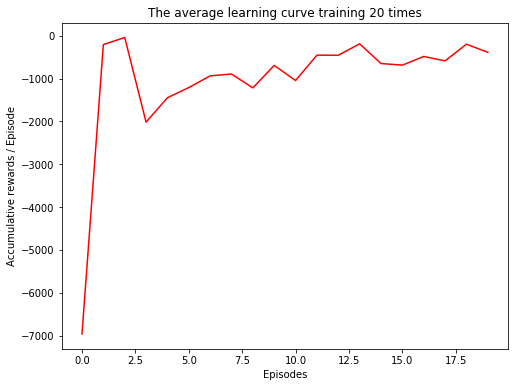

In [20]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(episodes), ret, color = 'r')
plt.xlabel('Episodes')
plt.ylabel('Accumulative rewards / Episode')
plt.title('The average learning curve training 20 times')
plt.show()